# Multi-layer Perceptron
This notebook is for training a multi-layer perceptron for classification on the heart dataset

### Imports:
The MLPClassifier from scikit-learn is used. In addition we use various functions from scikit-learn to help with the selection of model hyperparameters.

In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

### Data Loading
We load the cleaned data that was created in our EDA process. From that process, we also decided on 5 features to use. We select them here.

In [2]:

# Load the dataset from a CSV file
csv_file_path = '../dataset/heart_cleaned.csv'
data = pd.read_csv(csv_file_path)


#select our 4 features of interest
X = data[['oldpeak', 'exang', 'cp', 'thalach', 'ca']]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

### Grid Search
In order to find which hyperparameters to use, we perform a grid_search. This is done by selecting various options for each hyperparameter, and then searching through each combination. The cross-validation score is used to select which is best.

In [3]:

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(20,), (50,), (100,), (20,20), (50,20), (50,50), (100,20),],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.00025],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter':[1500],
    'random_state': [42]
}

# Initialize the MLPClassifier
mlp = MLPClassifier()

# Perform grid search
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.2f}")

# Use the best estimator to predict
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy with best parameters: {accuracy:.2f}")

Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'constant', 'max_iter': 1500, 'random_state': 42, 'solver': 'adam'}
Best accuracy: 0.81
Test set accuracy with best parameters: 0.76


### Optimal Hyperparameters
The result from the above grid search shows us that the best combination of hyperparameters we searched through is:
- relu activation
- 0.0001 alpha
- 2 hidden layer of 20 neurons each
- constant lr
- 1500 epochs
- adam solver

### Learning Curve
Here we define a function to plot the learning curve. We plot cv-score, training accuracy, and testing accuracy as a function of the number of epochs.

In [4]:

# Function to plot learning curve
def epochs_learning_curve(X_train, X_test, y_train, y_test, model_initializer, epochs_sizes=range(1, 1000, 50)):
    # Initialize lists to store scores
    train_scores = []
    cv_scores = []
    test_scores = []

    # Loop over different training sizes
    for epochs in epochs_sizes:
        model = model_initializer(epochs)


        #get cross-fold validation score
        cv_score = cross_val_score(model_initializer(epochs), X_train, y_train, cv=5)
        cv_scores.append(cv_score.mean())

        # Train the model on the subset
        model.fit(X_train, y_train)

        # Evaluate on the training subset
        train_pred = model.predict(X_train)
        train_score = accuracy_score(y_train, train_pred)
        train_scores.append(train_score)

        # Evaluate on the full test set
        test_pred = model.predict(X_test)
        test_score = accuracy_score(y_test, test_pred)
        test_scores.append(test_score)

    # Convert scores to numpy arrays for easier handling
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    cv_scores = np.array(cv_scores)

    # Plot the learning curve
    plt.figure()
    plt.title("Learning Curve (MLPClassifier)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid()

    plt.plot(epochs_sizes, train_scores, 'o-', color="r", label="Training Accuracy")
    plt.plot(epochs_sizes, cv_scores, 'o-', color="y", label="CV Accuracy")
    plt.plot(epochs_sizes, test_scores, 'o-', color="g", label="Validation Accuracy")

    plt.legend(loc="best")
    plt.show() 
    print(f"Highest Train: {round(train_scores.max(),2)}")
    print(f"Highest CV Average: {round(cv_scores.max(),2)}")
    print(f"Highest Test: {round(test_scores.max(),2)}")

Now use the function to make the learning curve graphic

C:\Users\nicho\miniconda3\envs\seancaroll\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nicho\miniconda3\envs\seancaroll\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nicho\miniconda3\envs\seancaroll\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nicho\miniconda3\envs\seancaroll\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nic

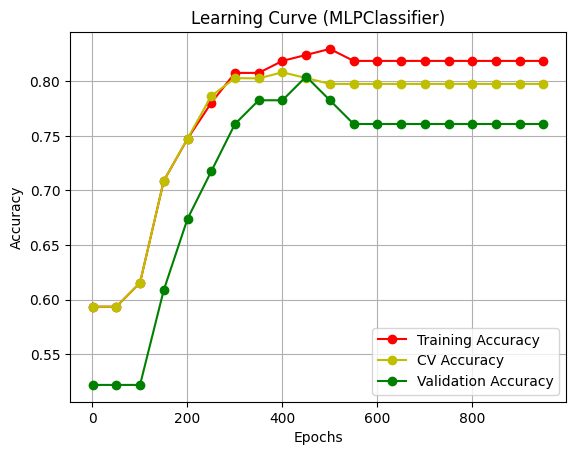

Highest Train: 0.83
Highest CV Average: 0.81
Highest Test: 0.8


In [5]:

def model_initializer(epochs):
    params = grid_search.best_params_
    params['max_iter'] = epochs
    return MLPClassifier(**params)
# Plot learning curve
epochs_learning_curve(X_train, X_test, y_train, y_test, model_initializer=model_initializer)
plt.show()

### Conclusion
We can see from the learning curve that the model performance improveswith the number of epochs. At about 550 epochs, the model converges to a steady state. The peak training accuracy is 83%, while peak CV-average is 81% and peak testing accuracy is 80%. Because the Validation and Training accuracy are very close, we can assume that there is not very much overfitting